### 0. Import libraries, load data and define constants

In [1]:
import os
import re
import copy
import json

# package needed to parse a PDF
import fitz

# library used to display a PDF page
import pdfplumber


In [2]:
# directory path with all PDFs
DATA_FOLDER = "../fetch_flyers/flyers/"

# path of the stored results
OUTPUT_FILE_PATH = "./data/flyers_text.json"

# padding needed to avoid the extraction of useless info
PADDING_WIDTH_PER = 0.0
PADDING_HEIGHT_PER = 0.1

# separator between sections
SECTION_SEPARATOR = "\n \n"

### 1. Example of a PDF page with detected text

Number of PDFs: 1320
PDF name: (Langdurig) gebroken vliezen.pdf


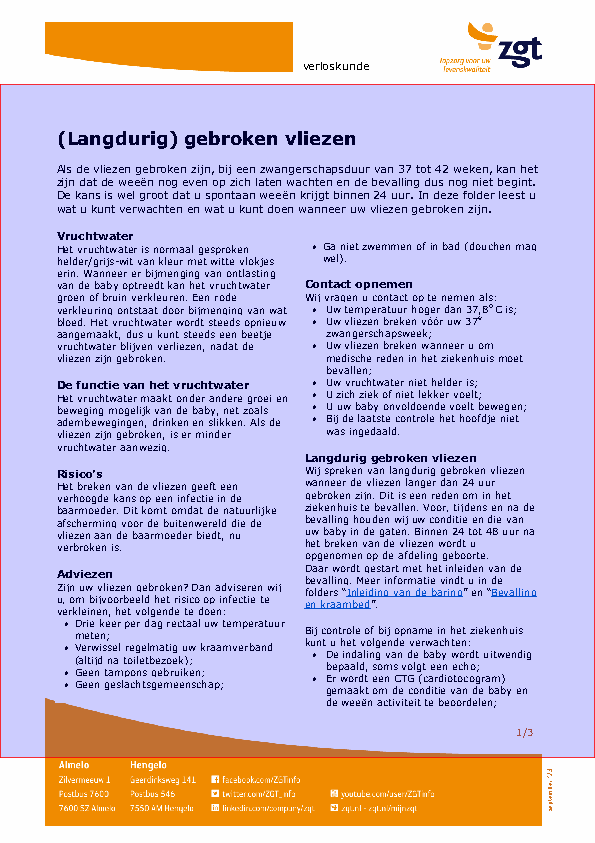

In [3]:
# include a diverse set of PDFs with edge cases
representative_pdf_names = [
    "(Langdurig) gebroken vliezen.pdf",
    "Aangifte van geboorte.pdf",
    "Aanvraagformulier vernietiging medische gegevens.pdf",
    "Acupunctuur  (Nocepta).pdf",
    "Aspirine neusprovocatie.pdf",
    "TAC, patiënteninformatie.pdf",
    "MRI, Endometriose.pdf",
    "Voedingsadviezen bij lactose intolerantie.pdf",
    "Chroom.pdf",
    "Colofonium.pdf",
    "Acnes (Nocepta).pdf",
]

# print number of available PDF files
pdf_names = os.listdir(DATA_FOLDER)
print(f"Number of PDFs: {len(pdf_names)}")

# pick a flyer and a page number and display it
pdf_name = representative_pdf_names[0]
pdf_page_no = 0

with pdfplumber.open(DATA_FOLDER + pdf_name) as pdf:
    print(f"PDF name: {pdf_name}")
    page = pdf.pages[pdf_page_no]
height = page.height
width = page.width
im = page.to_image()

im.draw_rect(
    (
        width * PADDING_WIDTH_PER,
        height * PADDING_HEIGHT_PER,
        width - width * PADDING_WIDTH_PER,
        height - height * PADDING_HEIGHT_PER,
    )
)


### 2. Identify tables and their bounding boxes

In [60]:
def find_tables(pdf_pages):
    """
    This function returns the bounding boxes for found tables from each page.
    """

    # store in this dictionary a list of tabels' bounding boxes associated with each page
    tables_bb = dict()

    for page_number, pdf_page in enumerate(pdf_pages):
        tables_bb[page_number] = []

        tabs = pdf_page.find_tables()

        for tab in tabs:
            tables_bb[page_number].append(tab.bbox)

    return tables_bb


### 3. Get font sizes

In [61]:
def get_majority_font_size(text_and_size, sizes_set):
    """
    This function retruns the font size used for the most characters in the PDF.
    """

    # count how many letters are written with each font
    text_size_counter = dict(zip(sizes_set, [0] * len(sizes_set)))

    for text, size in text_and_size.items():
        text_size_counter[size] += len(text.replace(" ", ""))
    # get the font size used to write the largest number of characters in the flyer
    most_frequent_font_size = sorted(
        text_size_counter.items(), key=lambda x: x[1], reverse=True
    )[0][0]

    return most_frequent_font_size


In [62]:
def extract_text_sizes(pdf_pages, rect):
    """
    It finds the font sizes used in the current PDF, the associated
    font size with each line and lines of text written with bold font.
    """

    # stores a set of all font size used throughout the document
    sizes_set = set()
    # stores for each line of text the font size
    text_and_size = dict()
    # store bold text
    bold_text = []

    # iterate over all pages
    for pdf_page_no in range(len(pdf_pages)):
        # read page text as a dictionary
        blocks = pdf_pages[pdf_page_no].get_text("dict", clip=rect)["blocks"]
        # iterate through the text blocks
        for b in blocks:
            # treat the case when it fails for images
            try:
                # iterate through the text lines
                for l in b["lines"]:
                    # iterate through the text spans
                    for s in l["spans"]:
                        # store the font size for each span of text
                        sizes_set.add(s["size"])
                        text_and_size[s["text"].strip()] = s["size"]

                        # if the text is written with bold font, store it separately
                        if ",Bold" in s["font"] and len(s["text"].strip()) > 0:
                            bold_text.append(s["text"].strip())
            except:
                pass

    return sizes_set, text_and_size, bold_text

In [63]:
def get_large_text(text_and_size, sizes_set):
    """
    Returns text and font size used for text written with a font size larger
    than the one used the most in the PDF. 
    """
    
    # get most frequent font size
    most_frequent_font_size = get_majority_font_size(text_and_size, sizes_set)

    # consider each font larger than the most frequent as an indicator of the beginning of a section
    large_text_and_size = {
        text: size for text, size in text_and_size.items() if size > most_frequent_font_size
    }

    # treat the case when the most frequent font is the largest one
    if len(large_text_and_size) == 0:
        large_text_and_size = {
            text: size
            for text, size in text_and_size.items()
            if size >= most_frequent_font_size
        }
    
    return large_text_and_size

### 4. Parse the PDF

#### 4.1. Separate text into sections

In [64]:
def extract_raw_sections(pdf_pages, rect, large_text_and_size, bold_text, sizes_set):
    """
    This function divides the PDF into raw sections based on separators and font features.
    """

    # store sections into a list
    extracted_sections = []

    # iterate over PDF pages
    for page_number, pdf_page in enumerate(pdf_pages):
        # extract text from page
        text = pdf_page.get_text(clip=rect)

        # iterate over sections
        for section in text.split(SECTION_SEPARATOR):
            # get all non-space characters
            only_text = re.sub(r"\s+", "", section)

            # do not process empty sections
            if len(only_text) != 0:
                # remove empty lines or ones that contain only the page number
                current_section = [
                    line
                    for line in section.split("\n")
                    if len(re.sub(r"\s+", "", line)) > 0
                    and re.sub(r"\s+", "", line) != f"{page_number + 1}/{len(pdf_pages)}"
                ]
                current_extracted_sections = []

                # iterate over lines in the section
                for index, line in enumerate(current_section):
                    # check if current line is a header or not
                    is_header = False
                    for text_, size in large_text_and_size.items():
                        # if text is bold and large
                        if line.strip() == text_ and (line.strip() in bold_text or size == max(sizes_set)):
                            is_header = True
                    # if it's the first line in the section and is bold
                    if line.strip() in bold_text and index == 0:
                        is_header = True
                    # if it's not a header, append line to the previous section
                    if not is_header:
                        if len(current_extracted_sections) == 0:
                            current_extracted_sections.append([line])
                        else:
                            current_extracted_sections[-1].append(line)
                    # otherwise, start a new section based on the found header
                    else:
                        # also add the header tag
                        current_extracted_sections.append(["HEADER::" + line])
                # after processing the sections, add them to the list
                extracted_sections.append(current_extracted_sections)

    return extracted_sections

#### 4.2. Remove header tags when unnecessary

In [65]:
def remove_unnecessary_header_tags(extracted_sections, text_and_size):
    """
    Remove the header tags for specific sections that were wrongly identified
    as composed by multiple headers.
    """

    # create a codpy of the extracted sections
    filtered_extracted_sections = copy.deepcopy(extracted_sections)

    # iterate over sections
    for section_index, section in enumerate(extracted_sections):
        # check if each subsection starts with a header
        only_headers = len(section) == len(
            [True for subsection in section if "HEADER::" in subsection[0]]
        )

        # store a set of font sizes used in the current section
        sizes = set()

        # for each line of each subsection store the used font size
        for subsection in section:
            for line in subsection:
                try:
                    sizes.add(
                        text_and_size[
                            line.replace("HEADER::", "").replace("\uf0b7", "").strip()
                        ]
                    )
                except:
                    pass
        # remove the header tag from each subsection these conditions are met
        if len(sizes) == 1 and only_headers and len(section) > 1:
            filtered_section = []

            for filtered_subsection_index in range(
                len(filtered_extracted_sections[section_index])
            ):
                for line in filtered_extracted_sections[section_index][
                    filtered_subsection_index
                ]:
                    filtered_section.append(line.replace("HEADER::", ""))
            # replace the section with the filtered one
            filtered_extracted_sections[section_index] = [filtered_section]

    return filtered_extracted_sections

#### 4.3. Flatten sections

In [66]:
def flatten_sections(filtered_extracted_sections):
    """
    This treats each subsection as a section.
    """

    # store each subsection as a standalone section
    flat_sections = []

    for outter_section in filtered_extracted_sections:
        for inner_section in outter_section:
            flat_sections.append(inner_section)
        
    return flat_sections


#### 4.4. Merge sections

In [67]:
def merge_sections(flat_sections):
    """ 
    This functions merges sections that do not have header with the previous section
    and header-only sections with the following sections.
    """

    all_sections_created = False

    # merge sections until all possible merges have been made
    while not all_sections_created:
        all_sections_created = True

        # iterate over sections starting from the second one
        for section_index in range(1, len(flat_sections)):
            # if current section does not start with a header, join it with the previous one
            if "HEADER::" not in flat_sections[section_index][0]:
                flat_sections[section_index - 1].extend(flat_sections[section_index])
                del flat_sections[section_index]
                all_sections_created = False
                break
            # if the previous section is header only, append to it the current one
            if (
                len(flat_sections[section_index - 1]) == 1
                and "HEADER::" in flat_sections[section_index - 1][0]
            ):
                flat_sections[section_index - 1][0] += flat_sections[section_index][
                    0
                ].replace("HEADER::", "")
                flat_sections[section_index - 1].extend(flat_sections[section_index][1:])
                del flat_sections[section_index]
                all_sections_created = False
                break

    return flat_sections


#### 4.5. Format and display extracted sections

In [68]:
def clean_text(text):
    """
    This function formats the text for storage and use purposes.
    """

    cleaned_text = (
        re.sub(r" +", " ", text)
        .replace("\uf0b7", "\n-")
        .replace("•", "\n-")
        .strip()
        .strip("\n")
        .strip("\t")
    )

    return cleaned_text

In [69]:
def format_sections(flat_sections, display_sections=False):
    """
    It cleans the header and section text and store pairs for header and
    section text in a dictionary. Additionally, it can print the extracted sections. 
    """

    # store extracted sections in this dictionary
    headers_sections = dict()

    # store header as key and section text as value
    for section in flat_sections:
        # clean header and section text
        header = clean_text(section[0].replace("HEADER::", ""))
        section = clean_text(" ".join(section[1:]))

        # do not store empty sections
        if len(re.sub(r" +", " ", section)) == 0:
            continue

        # treat the case when the header already exists in the dictionary
        if header in list(headers_sections.keys()):
            header += " "
        # add data
        headers_sections[header] = section

        #  Display extracted sections
        if display_sections:
            print(f"HEADER: {header}\n{section}\n{32 * "-"}\n")

    return headers_sections

### 5. Run pipeline for processing all PDFs

In [70]:
# define dictionary that will store each parsed pdf
parsed_pdfs = dict()

# parse each pdf
for pdf_name in pdf_names:
    # load flyer
    pdf_pages = fitz.open(DATA_FOLDER + pdf_name)

    # define the rectangle from which text is extracted
    width = pdf_pages[0].rect.width
    height = pdf_pages[0].rect.height
    rect = fitz.Rect(
        width * PADDING_WIDTH_PER,
        height * PADDING_HEIGHT_PER,
        width - width * PADDING_WIDTH_PER,
        height - height * PADDING_HEIGHT_PER,
    )

    # get font info
    sizes_set, text_and_size, bold_text = extract_text_sizes(pdf_pages, rect)
    large_text_and_size = get_large_text(text_and_size, sizes_set)

    # extract raw sections
    extracted_sections = extract_raw_sections(
        pdf_pages, rect, large_text_and_size, bold_text, sizes_set
    )

    # remove wrongly placed header tags
    filtered_extracted_sections = remove_unnecessary_header_tags(
        extracted_sections, text_and_size
    )

    # flattens sections and subsections
    flat_sections = flatten_sections(filtered_extracted_sections)

    # unify sections
    flat_sections = merge_sections(flat_sections)

    # clean data and store it in a dictionary
    headers_sections = format_sections(flat_sections)

    # store data for the current pdf
    parsed_pdfs[pdf_name.replace(".pdf", "")] = headers_sections

    # save data locally in JSON format
    with open(OUTPUT_FILE_PATH, "w") as file:
        file.write(json.dumps(parsed_pdfs, indent=4))


### 6. Display representative processed PDFs

In [13]:
# load results
with open(OUTPUT_FILE_PATH) as file:
    pdf_data = json.load(file)

In [14]:
# display most representative PDFs
for filename, data in dict(pdf_data).items():
    if filename + ".pdf" in representative_pdf_names:
        print(f"{32*'-'}\n{filename}")
        for header, section in data.items():
            print(f"\nHEADER:{header}\n{section}\n")

--------------------------------
(Langdurig) gebroken vliezen

HEADER:(Langdurig) gebroken vliezen
Als de vliezen gebroken zijn, bij een zwangerschapsduur van 37 tot 42 weken, kan het zijn dat de weeën nog even op zich laten wachten en de bevalling dus nog niet begint. De kans is wel groot dat u spontaan weeën krijgt binnen 24 uur. In deze folder leest u wat u kunt verwachten en wat u kunt doen wanneer uw vliezen gebroken zijn.


HEADER:Vruchtwater
Het vruchtwater is normaal gesproken helder/grijs-wit van kleur met witte vlokjes erin. Wanneer er bijmenging van ontlasting van de baby optreedt kan het vruchtwater groen of bruin verkleuren. Een rode verkleuring ontstaat door bijmenging van wat bloed. Het vruchtwater wordt steeds opnieuw aangemaakt, dus u kunt steeds een beetje vruchtwater blijven verliezen, nadat de vliezen zijn gebroken.


HEADER:De functie van het vruchtwater
Het vruchtwater maakt onder andere groei en beweging mogelijk van de baby, net zoals adembewegingen, drinken en 